# Assignment 4

In [0]:

import pandas as pd
import numpy as np
import datetime
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from os import listdir
from os.path import isfile, join
from PIL import Image

path = '/content/gdrive/My Drive/Colab Notebooks/input/JPEGImages'

imagesPaths = [f for f in listdir(path) if isfile(join(path, f))]

### Uploading the images and creating the dataset in sizes: 72x72, 144x144, 288x288

In [0]:
from matplotlib.pyplot import imshow

X = []
Y_mid = []
Y_large = []

for imagePath in imagesPaths[:200]:
    image = Image.open(join(path,imagePath),'r')
    X.append(np.asarray(image.resize((72,72), Image.ANTIALIAS)))
    Y_mid.append(np.asarray(image.resize((144,144), Image.ANTIALIAS)))
    Y_large.append(np.asarray(image.resize((288,288), Image.ANTIALIAS)))

In [0]:
X = np.asarray(X)
Y_mid = np.asarray(Y_mid)
Y_large = np.asarray(Y_large)

In [6]:
print(X.shape)
print(Y_mid.shape)
print(Y_large.shape)


(200, 72, 72, 3)
(200, 144, 144, 3)
(200, 288, 288, 3)


### Train-Test-Split

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val,Y_mid_train, Y_mid_val,Y_large_train, Y_large_val = train_test_split(X,Y_mid,Y_large, test_size=0.2)


In [8]:
print(X_train.shape)
print(X_val.shape)
print(Y_mid_train.shape)
print(Y_mid_val.shape)
print(Y_large_train.shape)
print(Y_large_val.shape)

(160, 72, 72, 3)
(40, 72, 72, 3)
(160, 144, 144, 3)
(40, 144, 144, 3)
(160, 288, 288, 3)
(40, 288, 288, 3)


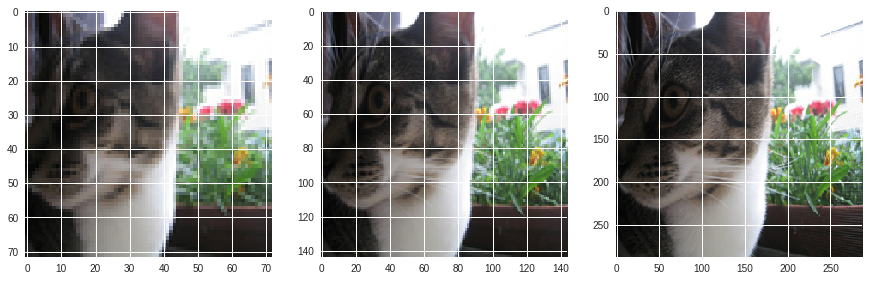

In [9]:
fig=plt.figure(figsize=(15, 15))

fig.add_subplot(1, 3, 1)
plt.imshow(X[1])
fig.add_subplot(1, 3, 2)
plt.imshow(Y_mid[1])
fig.add_subplot(1, 3, 3)
plt.imshow(Y_large[1])
plt.show()

In [10]:
from keras.models import Model,Sequential
from keras.layers import * # Dense, Embedding, LSTM
from keras.applications import VGG16

Using TensorFlow backend.


## Initial Model

The initial model will be a simple one that fits on X_train and Y_mid_train data samples. The output is supposed to be in size 144x144.

In [0]:
inp = Input(shape=(None,None,3))
model = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(inp)
model = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model)
model = UpSampling2D()(model)
out = Conv2D(filters = 3, kernel_size = 1, padding = 'same')(model)
model = Model(inputs=inp, outputs=out)
model.compile(optimizer='adam', loss='mse')

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 64)    256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 64)    4160      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, None, None, 64)    0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 3)     195       
Total params: 4,611
Trainable params: 4,611
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_train,Y_mid_train,epochs = 5,batch_size = 5, validation_data=(X_val,Y_mid_val))

Train on 160 samples, validate on 40 samples
Epoch 1/5
160/160 [==============================] - 4s 25ms/step - loss: 3362.4527 - val_loss: 311.2812
Epoch 2/5
160/160 [==============================] - 4s 24ms/step - loss: 295.8534 - val_loss: 268.2901
Epoch 3/5
160/160 [==============================] - 4s 24ms/step - loss: 242.7256 - val_loss: 249.7922
Epoch 4/5
160/160 [==============================] - 4s 24ms/step - loss: 235.8393 - val_loss: 247.7241
Epoch 5/5
160/160 [==============================] - 4s 24ms/step - loss: 233.9217 - val_loss: 246.6868


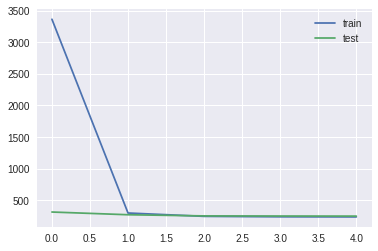

In [24]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(40, 144, 144, 3)


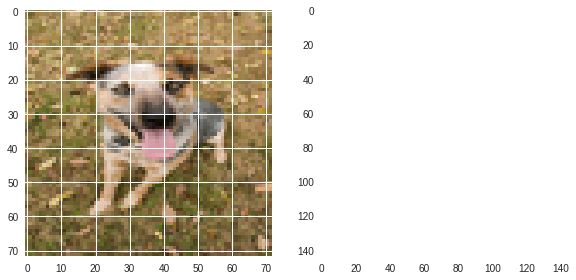

In [25]:
preds = model.predict(X_val)
preds = np.asarray(preds)

print(preds.shape)
fig=plt.figure(figsize=(15, 15))
fig.add_subplot(1, 3, 1)
plt.imshow(X_val[1])
fig.add_subplot(1, 3, 2)
plt.imshow(preds[1])
plt.show()

The predictions are blank white images. The model is not doing the job, lets improve it to see some results. 

## Resnet block

We define the Resnet Block which will use to enhance the model.

In [0]:
def resnetBlock():
    inp = Input(shape=(None,None,64))
    x= Conv2D(filters = 64, kernel_size = 3, padding = 'same')(inp)
    x= Conv2D(filters = 64, kernel_size = 3, padding = 'same')(x)
    out = Add()([inp,x])
    out = Activation('relu')(out)
    return Model(output = out,input = inp)

In [27]:
resnetBlock().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 6 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, None, None, 6 36928       input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, None, None, 6 36928       conv2d_10[0][0]                  
__________________________________________________________________________________________________
add_1 (Add)                     (None, None, None, 6 0           input_4[0][0]                    
                                                                 conv2d_11[0][0]                  
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  import sys


## Adding a second output and Resnet Block:

We enhance our model by adding the Resnet Block before every UpSampling2D. Also, a second output in size 288x288 will be produced by the model.

In [28]:
inp = Input(shape=(None,None,3))
model2 = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(inp)
model2 = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model2)
model2 = resnetBlock()(model2)
model2 = UpSampling2D()(model2)
mid_out = Conv2D(filters = 3, kernel_size = 1, padding = 'same')(model2)
model2 = resnetBlock()(model2)
model2 = UpSampling2D()(model2)
large_out = Conv2D(filters = 3, kernel_size = 1, padding = 'same')(model2)

model2 = Model(inputs=inp,outputs=[mid_out,large_out])
model2.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  import sys


## Adding VGG16 Features:

Lets take use the 'block1_conv2' as the feature extractor for our model.  We will concatenate the features with the original input.

In [29]:
vgg = VGG16(weights='imagenet', include_top = False)
vgg = Model(inputs=vgg.input, outputs=vgg.get_layer('block1_conv2').output)
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


In [0]:
vgg_inp = vgg.predict(X_train)


In [77]:
inp = Input(shape=(None,None,3))
vgg_fe = vgg(inp)
model2 = concatenate([inp,vgg_fe])
model2 = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model2)
model2 = BatchNormalization()(model2)
model2 = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model2)
model2 = BatchNormalization()(model2)
model2 = resnetBlock()(model2)
model2 = UpSampling2D()(model2)
mid_out = Conv2D(filters = 3, kernel_size = 1, padding = 'same')(model2)
mid_out = BatchNormalization()(mid_out)
model2 = resnetBlock()(model2)
model2 = UpSampling2D()(model2)
large_out = Conv2D(filters = 3, kernel_size = 1, padding = 'same')(model2)
large_out = BatchNormalization()(large_out)

model2 = Model(inputs=inp,outputs=[mid_out,large_out])
model2.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  import sys


In [78]:
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
model_8 (Model)                 (None, None, None, 6 38720       input_23[0][0]                   
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, None, None, 6 0           input_23[0][0]                   
                                                                 model_8[6][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, None, None, 6 4352        concatenate_6[0][0]              
__________

In [79]:
history = model2.fit(X_train,[Y_mid_train,Y_large_train],epochs = 10,batch_size = 5, validation_data=(X_val,[Y_mid_val,Y_large_val]))

Train on 160 samples, validate on 40 samples
Epoch 1/10
160/160 [==============================] - 91s 568ms/step - loss: 31119.4356 - batch_normalization_13_loss: 15479.5764 - batch_normalization_14_loss: 15639.8594 - val_loss: 28967.2085 - val_batch_normalization_13_loss: 14393.7452 - val_batch_normalization_14_loss: 14573.4631
Epoch 2/10
160/160 [==============================] - 89s 559ms/step - loss: 31079.3123 - batch_normalization_13_loss: 15460.9225 - batch_normalization_14_loss: 15618.3899 - val_loss: 29002.2795 - val_batch_normalization_13_loss: 14413.1620 - val_batch_normalization_14_loss: 14589.1173
Epoch 3/10
160/160 [==============================] - 89s 559ms/step - loss: 31056.2277 - batch_normalization_13_loss: 15449.6361 - batch_normalization_14_loss: 15606.5919 - val_loss: 28939.4951 - val_batch_normalization_13_loss: 14392.2692 - val_batch_normalization_14_loss: 14547.2256
Epoch 4/10
160/160 [==============================] - 89s 558ms/step - loss: 31032.7603 - batc

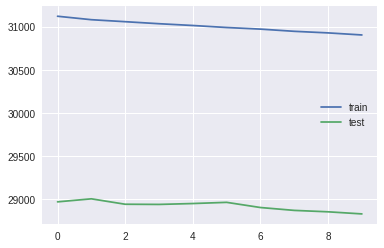

In [80]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Lets look at the predictions of the model after training.

In [0]:
preds = model2.predict(X_val)
mid_preds = np.asarray(preds[0])
large_preds = np.asarray(preds[1])

In [0]:
def printImages(index):
  fig=plt.figure(figsize=(15, 15))

  fig.add_subplot(1, 3, 1)
  plt.imshow(X_val[index])
  fig.add_subplot(1, 3, 2)
  plt.imshow(mid_preds[index])
  fig.add_subplot(1, 3, 3)
  plt.imshow(large_preds[index])
  plt.show()

In [83]:
print(mid_preds.shape)
print(large_preds.shape)

(40, 144, 144, 3)
(40, 288, 288, 3)


The shapes of the outputs correspond to the expected size. lets look some samples and their model outputs.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


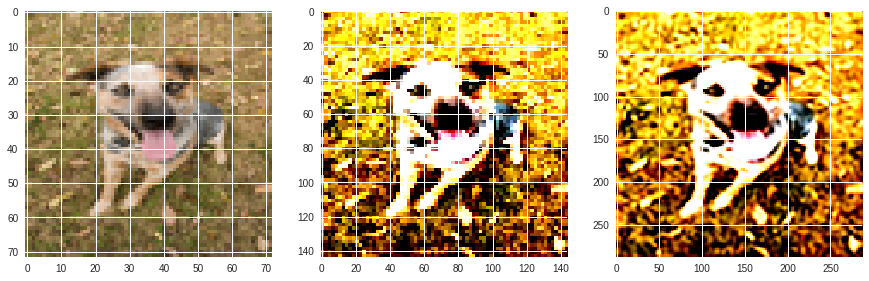

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


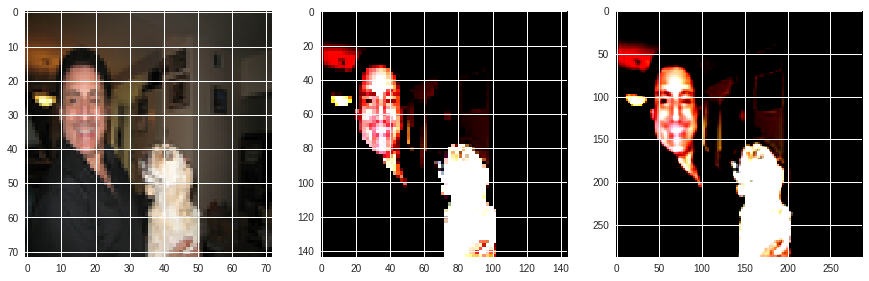

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


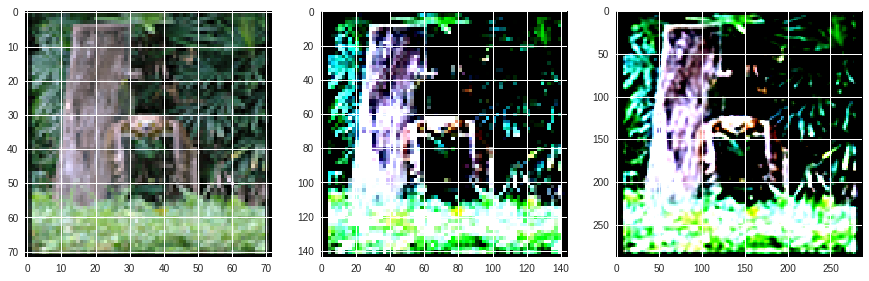

In [84]:
printImages(1)
printImages(2)
printImages(3)

We can see some results now. but it seems that the models prediction are not in range of 0..255 RGB data. 

The things we tried to improve the performance:


#### Run the model for more epochs


*   At first try we ran the model for 5 epochs which yielded not good results. running the model for 20 epochs didnt improve much.


#### Adding BatchNormalization
- Adding the batch normalization actually worked and produced some results but the saturation of the models results is very high compared to the original image.



### Replacing the UpSampling2D with depth_to_space

We will switch the UpSampling2D layer with the depth_to_space function layer and repeat the process.

In [0]:
import tensorflow as tf


In [87]:
inp = Input(shape=(None,None,3))
vgg_fe = vgg(inp)
model3 = concatenate([inp,vgg_fe])
model3 = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model3)
model3 = BatchNormalization()(model3)
model3 = Conv2D(filters = 64, kernel_size = 1, padding = 'same')(model3)
model3 = BatchNormalization()(model3)
model3 = resnetBlock()(model3)
model3 = Lambda(lambda x: tf.nn.depth_to_space(x,block_size=2))(model3)
mid_out = Conv2D(filters = 3, kernel_size = 1, padding = 'same')(model3)
mid_out = BatchNormalization()(mid_out)
#model3 = resnetBlock()(model3)
model3 = Lambda(lambda x: tf.nn.depth_to_space(x,block_size=2))(model3)
large_out = Conv2D(filters = 3, kernel_size = 1, padding = 'same')(model3)
large_out = BatchNormalization()(large_out)

model3 = Model(inputs=inp,outputs=[mid_out,large_out])
model3.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  import sys


In [88]:
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
model_8 (Model)                 (None, None, None, 6 38720       input_29[0][0]                   
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, None, None, 6 0           input_29[0][0]                   
                                                                 model_8[8][0]                    
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, None, None, 6 4352        concatenate_8[0][0]              
__________

In [89]:
history = model3.fit(X_train,[Y_mid_train,Y_large_train],epochs = 10,batch_size = 5, validation_data=(X_val,[Y_mid_val,Y_large_val]))

Train on 160 samples, validate on 40 samples
Epoch 1/10
160/160 [==============================] - 36s 223ms/step - loss: 31152.2856 - batch_normalization_20_loss: 15492.4379 - batch_normalization_21_loss: 15659.8479 - val_loss: 29031.9717 - val_batch_normalization_20_loss: 14462.6243 - val_batch_normalization_21_loss: 14569.3478
Epoch 2/10
160/160 [==============================] - 33s 204ms/step - loss: 31094.2242 - batch_normalization_20_loss: 15462.2778 - batch_normalization_21_loss: 15631.9464 - val_loss: 29100.9094 - val_batch_normalization_20_loss: 14474.3607 - val_batch_normalization_21_loss: 14626.5485
Epoch 3/10
160/160 [==============================] - 32s 203ms/step - loss: 31068.8785 - batch_normalization_20_loss: 15450.7107 - batch_normalization_21_loss: 15618.1678 - val_loss: 29132.3333 - val_batch_normalization_20_loss: 14467.3698 - val_batch_normalization_21_loss: 14664.9634
Epoch 4/10
160/160 [==============================] - 33s 203ms/step - loss: 31042.6545 - batc

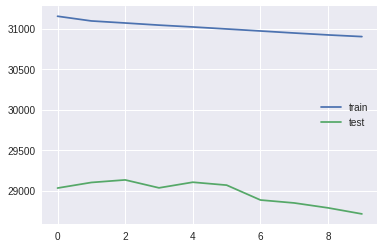

In [90]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
preds = model3.predict(X_val)
mid_preds = np.asarray(preds[0])
large_preds = np.asarray(preds[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


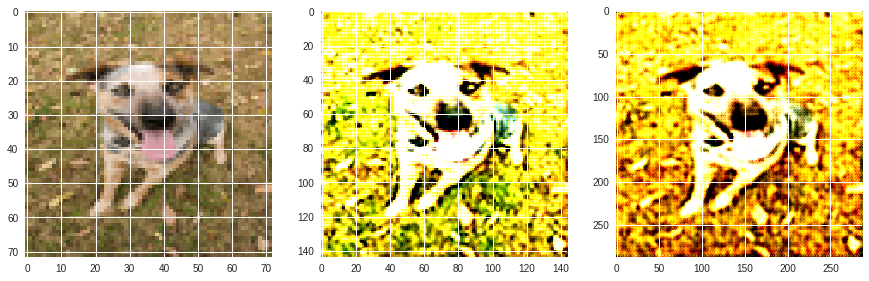

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


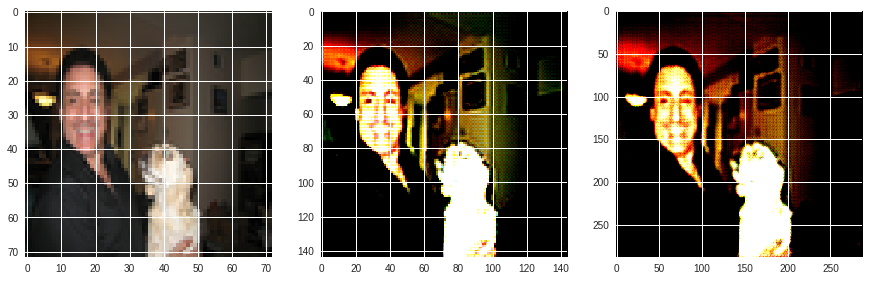

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


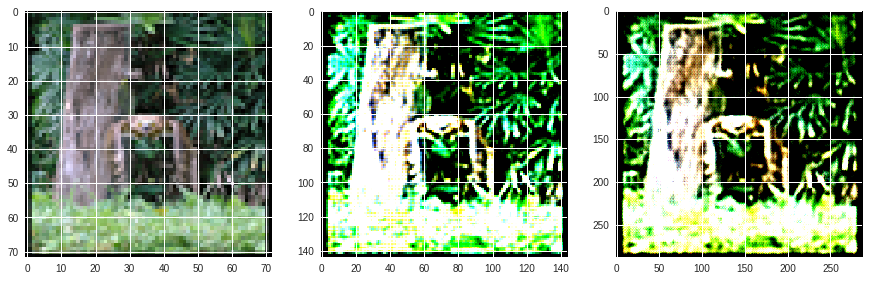

In [92]:

printImages(1)
printImages(2)
printImages(3)

We can see that the model produces pretty good results after all the enhancements and parameter tuning. 